# setup

In [1]:
import os, sys, json, math, random
from dataclasses import asdict

import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch.utils.data import DataLoader, Subset
from torch.optim import AdamW
from torch.cuda.amp import GradScaler

# --- project root & local modules ---
PROJ_ROOT = "/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation"
sys.path.append(os.path.join(PROJ_ROOT, "src"))

from otu_taxa.helpers_pretraining_model import MetricsLogger, set_seed, save_checkpoint, IGNORE_INDEX
from otu_taxa.trainer_hier_joint_unk import run_epoch

from otu_taxa.joint_hier_loss_metrics_unk import make_factorized_tax_loss_fn_fast_masked_with_unk
from otu_taxa.otu_taxa_transformer_unk import ModelConfig, OTUTaxaTransformerEmbedTaxTreeUnkTaxa
from otu_taxa.dataloaders_unk_balanced import (
    OTUTaxaDataset,
    MaskingConfig,
    make_collator_balanced,
    build_tax2ancestor_at_rank,
)


# data

In [2]:
# -----------------------------------
# Paths & config (single source of truth)
# -----------------------------------
PROJ_ROOT = "/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation"

# External (heavy) dataset location (outside repo)
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = "dataset_full_top999"   # <- adjust if you used a different name
dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

# Base dataset artifacts
TAXONOMY_VOCAB_PATH = os.path.join(dataset_dir, "taxonomy_vocab.json")
path_to_taxonomy_tree = os.path.join(dataset_dir, "taxonomy_nested.json")
SAMPLES_JSONL = os.path.join(dataset_dir, "samples.jsonl")

# Tree artifacts directory (derived)
TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")

# LCA (prefer .npy in new pipeline; keep CSV fallback if you still have it)
LCA_NPY = os.path.join(TREE_DIR, "lca_distance_edges.npy")
LCA_CSV = os.path.join(TREE_DIR, "lca_distance_edges.csv")  # optional legacy

# Descendant matrices
DESCENDANT_MATRIX_PATH = os.path.join(TREE_DIR, "descendant_matrix.npy")              # real tree only
UNK_VOCAB_PATH         = os.path.join(TREE_DIR, "taxonomy_vocab_with_unk.json")       # real + 7 UNKs
UNK_M_PATH             = os.path.join(TREE_DIR, "descendant_matrix_with_unk.npy")     # real+UNK closure
RANK_IDX_PATH          = os.path.join(TREE_DIR, "rank_idx.npy")                       # rank per token (0..6)

# # Optional: test split ids (only if you created it for the full corpus)
# TEST_IDS_PATH = os.path.join(dataset_dir, "splits", "test_samples_2000.txt")  # adjust if needed

# Run / output dir (inside repo)
run_name = "pretrain_tail_80_otus_200"
out_dir = os.path.join(PROJ_ROOT, "runs_microbeatlas_k_shot", run_name)
os.makedirs(out_dir, exist_ok=True)

# -----------------------------------
# Load LCA distance matrix
# -----------------------------------
if os.path.exists(LCA_NPY):
    D_tree = torch.from_numpy(np.load(LCA_NPY)).float()
else:
    df_D = pd.read_csv(LCA_CSV, index_col=0)
    D_tree = torch.tensor(df_D.values, dtype=torch.float32)

print("LCA distance matrix:", D_tree.shape)

# save logs
metrics_path = os.path.join(out_dir, "metrics.jsonl")
logger = MetricsLogger(metrics_path)

# -----------------------------------
# Taxonomy sizes: T_real vs T_base
# -----------------------------------
# ORIGINAL vocab (no UNKs), for tree regularizer and T_real
with open(TAXONOMY_VOCAB_PATH, "r") as f:
    tax_vocab_real = json.load(f)
T_real = len(tax_vocab_real)
print("T_real (original taxa, just k UNK):", T_real)

# UNK-extended vocab & descendant matrix for hierarchical loss
with open(UNK_VOCAB_PATH, "r") as f:
    tax_vocab_unk = json.load(f)
T_base = len(tax_vocab_unk)
print("T_base (real + UNK):", T_base)

# Load UNK-extended descendant matrix (used by hierarchical loss)
D_np_unk = np.load(UNK_M_PATH)          # [T_base, T_base]
M_tensor = torch.from_numpy(D_np_unk)   # keep name M_tensor for the loss
print("Descendant matrix with UNK:", M_tensor.shape)

# Optional: real-only descendant matrix (if needed for debugging)
D_np_real = np.load(DESCENDANT_MATRIX_PATH)        # [T_real, T_real]
descendant_matrix_real = torch.from_numpy(D_np_real)
print("Descendant matrix (real only):", descendant_matrix_real.shape)

# Optional: rank_idx (often used by loss/metrics/collator)
rank_idx = np.load(RANK_IDX_PATH)  # shape [T_base]
print("rank_idx:", rank_idx.shape)


LCA distance matrix: torch.Size([6929, 6929])
T_real (original taxa, just k UNK): 6929
T_base (real + UNK): 6935
Descendant matrix with UNK: torch.Size([6935, 6935])
Descendant matrix (real only): torch.Size([6929, 6929])
rank_idx: (6935,)


In [3]:
# -----------------------------------
# Training hyperparameters
# -----------------------------------
seed = 123
device = "cuda" if torch.cuda.is_available() else "cpu"

epochs = 24
train_batch_size = int(32 * 2)
val_batch_size   = 64

max_len = 500                    # 96th percentile sequence length
mlm_prob = 0.15                  # masking rate
prob_joint, prob_otu_only, prob_tax_only = 0.50, 0.25, 0.25
keep_prob, random_prob = 0.10, 0.10


lr = 1e-3
weight_decay = 1e-3
warmup_ratio = 0.06
max_grad_norm = 1.0
grad_accum_steps = 2

TREE_LAMBDA = 10                 # tree regularization weight
num_workers = 0                  # 0 for determinism


In [4]:
# -----------------------------------
# Dataset & split from selected tail-OTU pool (saved JSON)
# Train = samples with NONE of the selected OTUs
# Test  = held-out samples with >=1 selected OTU
# Val   = random subset of Train (clean validation)
# -----------------------------------

set_seed(seed)
random.seed(seed)

# 1) Load full dataset once
ds = OTUTaxaDataset(dataset_dir)
N = len(ds)
print(f"[INFO] Dataset size: N={N}")

# 2) Load the precomputed split JSON saved next to THIS notebook
#    Example filename: split_tail80_nOTU200_seed0.json
split_path = Path.cwd() / "split_tail80_nOTU200_seed123.json"   # <-- EDIT if different
with open(split_path, "r") as f:
    split = json.load(f)

train_idx = sorted(split["train_indices"])
heldout_idx = sorted(split["heldout_indices"])  # this will be our TEST set

# Safety checks
assert len(train_idx) + len(heldout_idx) == N, "Split indices do not sum to N"
assert set(train_idx).isdisjoint(set(heldout_idx)), "Train/Heldout overlap detected"

print(f"[SPLIT:TAIL] Train(clean)={len(train_idx)}  Heldout={len(heldout_idx)}  (Total N={N})")
print(f"[SPLIT:TAIL] Heldout fraction = {len(heldout_idx)/N:.4f}")

# 3) Build a clean validation set by sampling from train_idx
#    Keep your old VAL_N logic, but constrained to train pool size.
VAL_N = min(20_000, len(train_idx))  # <-- adjust if you want 10k, etc.

train_idx_shuf = train_idx.copy()
random.shuffle(train_idx_shuf)

val_idx = sorted(train_idx_shuf[:VAL_N])
train_idx_final = sorted(train_idx_shuf[VAL_N:])

test_idx = heldout_idx  # heldout is the "test" set in this experiment

print(f"[SPLIT:FINAL] Train={len(train_idx_final)}  Val={len(val_idx)}  Test(heldout)={len(test_idx)}")

# 4) Subsets
train_ds = Subset(ds, train_idx_final)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)

# 5) Optional: quick reporting about the OTU pool used (from the JSON)
print("\n[OTU POOL INFO]")
print(f"  tail_quantile: {split.get('tail_quantile', 'NA')}")
print(f"  threshold_samples: {split.get('threshold_samples', 'NA')}")
print(f"  n_sampled_otus: {split.get('n_sampled_otus', 'NA')}")
print(f"  seed: {split.get('seed', 'NA')}")


[INFO] Dataset size: N=1836250
[SPLIT:TAIL] Train(clean)=1651900  Heldout=184350  (Total N=1836250)
[SPLIT:TAIL] Heldout fraction = 0.1004
[SPLIT:FINAL] Train=1631900  Val=20000  Test(heldout)=184350

[OTU POOL INFO]
  tail_quantile: 0.8
  threshold_samples: 4445
  n_sampled_otus: 200
  seed: 123


In [5]:
# -----------------------------------
# Collators & loaders
# -----------------------------------

# TRAIN collator: stochastic masking + BOTH balancing strategies
train_cfg = MaskingConfig(
    mlm_prob=mlm_prob,
    prob_joint=prob_joint,
    prob_otu_only=prob_otu_only,
    prob_tax_only=prob_tax_only,
    max_len=max_len,
    keep_prob=keep_prob,
    random_prob=random_prob,
    balance_mode="otu",
)

train_collate = make_collator_balanced(
    dataset=ds,
    cfg=train_cfg,
)

# VAL / TEST collator:
# Recommended: keep masking same, but DISABLE balancing (so evaluation is not distribution-shaped).
val_cfg = MaskingConfig(
    mlm_prob=mlm_prob,
    prob_joint=prob_joint,
    prob_otu_only=prob_otu_only,
    prob_tax_only=prob_tax_only,
    max_len=max_len,
    keep_prob=keep_prob,
    random_prob=random_prob,
    balance_mode="none",    # important: no endpoint re-selection for eval
)

val_collate = make_collator_balanced(
    dataset=ds,
    cfg=val_cfg,
)

test_collate = make_collator_balanced(
    dataset=ds,
    cfg=val_cfg,
)

train_loader = DataLoader(
    train_ds,
    batch_size=train_batch_size,
    shuffle=True,
    collate_fn=train_collate,
    num_workers=num_workers,
    pin_memory=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=val_batch_size,
    shuffle=False,
    collate_fn=val_collate,
    num_workers=0,
    pin_memory=True,
)

test_loader = DataLoader(
    test_ds,
    batch_size=val_batch_size,
    shuffle=False,
    collate_fn=test_collate,
    num_workers=0,
    pin_memory=True,
)
# -----------------------------------
# Model sizes & PAD ids (single place)
# -----------------------------------

# OTUs: unchanged
n_otus = ds.O + 2            # + pad, mask
pad_otu_id = ds.O

# TAXA (UNK-aware):
# - T_real = original number of taxa (from taxonomy_vocab.json)
# - T_base = len(tax_vocab_unk) = T_real + 7 (real + UNKs)
# - n_taxa = T_base + 2 (PAD, MASK at the end)
n_taxa = T_base + 2
pad_tax_id  = T_base         # PAD token index
mask_tax_id = T_base + 1     # MASK token index


# Load model

In [6]:
# -----------------------------
# Build model config
# -----------------------------
model_cfg = ModelConfig(
    d_model=256, n_layers=6, n_heads=4, d_ff=1024,
    dropout=0.1, activation="gelu",
    tie_otu_weights=True,
    otu_loss_weight=1.0,
    tax_loss_weight=1.0,
    #lambda_tree=TREE_LAMBDA,
    emb_dropout=0.1,
    layernorm_emb=True,
    #lca_csv=LCA_CSV,          # LCA over ORIGINAL taxonomy (T_real x T_real)
    T_real=T_real,            # <- NEW: number of original taxa for tree regularizer
)

# -----------------------------
# Hierarchical taxonomy loss (UNK-aware)
# -----------------------------
# Here we use the UNK-extended vocab and M_tensor that we loaded earlier:
#   - tax_vocab_unk: list[str], len = T_base = T_real + 7
#   - M_tensor: [T_base, T_base] descendant-closure with UNKs

def build_rank_idx_from_vocab(vocab_list):
    """
    Returns a LongTensor [len(vocab_list)] with rank indices 0..6 for k..s.
    Assumes tokens start with 'k:', 'p:', ..., 's:' (including UNK ones).
    """
    rank_map = {'k': 0, 'p': 1, 'c': 2, 'o': 3, 'f': 4, 'g': 5, 's': 6}
    out = []
    for name in vocab_list:
        ch = name[0].lower()
        out.append(rank_map.get(ch, -1))
    return torch.tensor(out, dtype=torch.long)

rank_idx = build_rank_idx_from_vocab(tax_vocab_unk)   # [T_base]

# build the UNK-aware hierarchical loss callable
hier_tax_loss_fn = make_factorized_tax_loss_fn_fast_masked_with_unk(
    M_tensor=M_tensor,          # [T_base, T_base] with UNKs
    rank_idx=rank_idx,          # [T_base]
    tax_vocab=tax_vocab_unk,    # len = T_base
    T_base=T_base,              # real + 7 UNKs
)

# -----------------------------
# Init model (UNK-aware)
# -----------------------------
model = OTUTaxaTransformerEmbedTaxTreeUnkTaxa(
    n_otus=n_otus,
    n_taxa=n_taxa,              # = T_base + 2 (PAD, MASK)
    pad_otu_id=pad_otu_id,
    pad_tax_id=pad_tax_id,
    config=model_cfg,
    tax_loss_fn=hier_tax_loss_fn,
).to(device)

# -----------------------------
# Optimizer & Scheduler
# -----------------------------
optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

steps_per_epoch = math.ceil(len(train_loader) / max(1, grad_accum_steps))
total_steps = steps_per_epoch * epochs
warmup_steps = max(1, int(warmup_ratio * total_steps))

def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return max(0.0, float(total_steps - current_step) / float(max(1, total_steps - warmup_steps)))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# AMP scaler
scaler = GradScaler(enabled=(device == "cuda"))

# -----------------------------
# Save run config
# -----------------------------
run_meta = {
    "seed": seed,
    "epochs": epochs,
    "train_batch_size": train_batch_size,
    "val_batch_size": val_batch_size,
    "max_len": max_len,
    "mlm_prob": mlm_prob,
    "prob_split": [prob_joint, prob_otu_only, prob_tax_only],
    "optimizer": {"lr": lr, "weight_decay": weight_decay},
    "sched": {
        "warmup_ratio": warmup_ratio,
        "total_steps": total_steps,
        "warmup_steps": warmup_steps,
    },
    "model_cfg": asdict(model_cfg),
    "dataset": {
        "N": N,
        "N_train": len(train_ds),
        "N_val": len(val_ds),
        "O": ds.O,
        # Keep both for clarity
        "T_real": T_real,       # original taxa (no UNK)
        "T_base": T_base,       # real + UNK (used by loss)
    },
}
with open(os.path.join(out_dir, "meta.json"), "w") as f:
    json.dump(run_meta, f, indent=2)

print(
    f"[INFO] Train={len(train_ds)}  Val={len(val_ds)}  "
    f"Steps/epoch={steps_per_epoch}  Total steps={total_steps}"
)


UNK ids per rank: [6928, 6929, 6930, 6931, 6932, 6933, 6934]


/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


[INFO] Train=1631900  Val=20000  Steps/epoch=12750  Total steps=306000


# training Model

In [7]:
rank_map = {'k':0, 'p':1, 'c':2, 'o':3, 'f':4, 'g':5, 's':6}
unk_ids_by_rank = {}

for idx, token in enumerate(tax_vocab_unk):
    # Expect tokens like "k:UNK", "p:UNK", ..., "s:UNK"
    # Adjust this condition if your naming is slightly different.
    if token.endswith("UNK") or token.endswith("unk"):
        prefix = token.split(":")[0]  # 'k','p',...,'s'
        if prefix in rank_map:
            r = rank_map[prefix]
            unk_ids_by_rank[r] = idx

print("UNK IDs per rank:", unk_ids_by_rank)
print("T_base:", T_base)

UNK IDs per rank: {0: 6928, 1: 6929, 2: 6930, 3: 6931, 4: 6932, 5: 6933, 6: 6934}
T_base: 6935


In [ ]:
best_val = float("inf")
global_step = 0

for epoch in range(1, epochs + 1):

    # ---- TRAIN ----
    train_stats, global_step = run_epoch(
        model=model,
        dataloader=train_loader,
        device=device,
        IGNORE_INDEX=IGNORE_INDEX,
        split="train",
        epoch=epoch,
        global_step=global_step,
        M_tensor=M_tensor,
        rank_idx=rank_idx,
        T_base=T_base,
        optimizer=optimizer,
        scheduler=scheduler,
        scaler=scaler,
        grad_accum_steps=grad_accum_steps,
        max_grad_norm=max_grad_norm,
        logger=logger,
        deterministic_masks=False,

        # NEW controls (UPDATED)
        metric_every_steps=1000,            # log train_step every 1000 optimizer steps
        train_metric_max_positions=2000,    # cap metric compute on probe batches
        progress_every_steps=50,
    )

    # ---- VALIDATION ----
    val_stats, _ = run_epoch(
        model=model,
        dataloader=val_loader,
        device=device,
        IGNORE_INDEX=IGNORE_INDEX,
        split="val",
        epoch=epoch,
        global_step=global_step,
        M_tensor=M_tensor,
        rank_idx=rank_idx,
        T_base=T_base,
        optimizer=None,
        scheduler=None,
        scaler=None,
        grad_accum_steps=1,
        max_grad_norm=max_grad_norm,
        logger=logger,
        deterministic_masks=True,

        # OPTIONAL: evaluate only a subset if val is huge
        # max_eval_batches=200,   # uncomment if needed

        progress_every_steps=0,
    )

    # save best checkpoint (still using val loss as criterion)
    if val_stats["loss"] < best_val:
        best_val = val_stats["loss"]
        save_checkpoint(
            os.path.join(out_dir, "best.pt"),
            model, optimizer, scheduler, scaler,
            epoch, global_step, best_val,
        )
        print(f"[E{epoch:02d}] ✅ Saved BEST")

# FINAL CHECKPOINT
save_checkpoint(
    os.path.join(out_dir, "last.pt"),
    model, optimizer, scheduler, scaler,
    epoch, global_step, best_val,
)


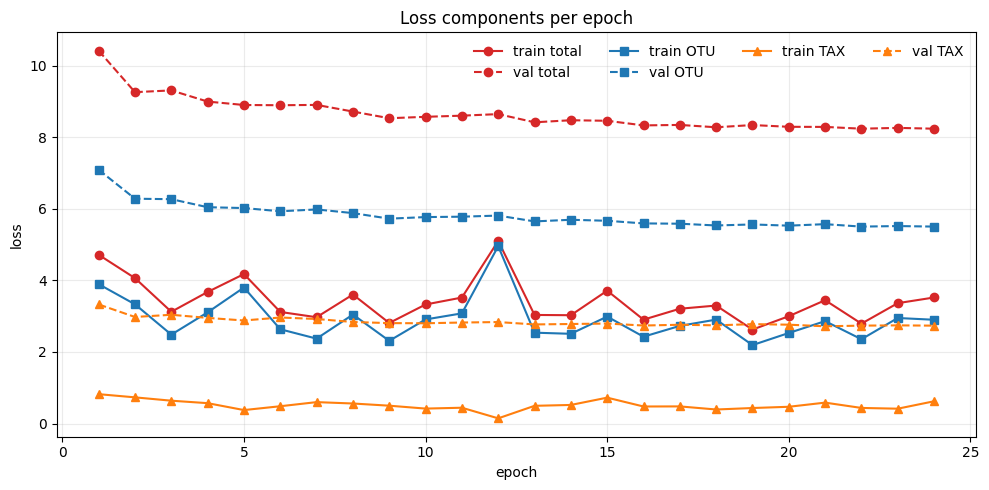

In [10]:
import json, pandas as pd, matplotlib.pyplot as plt

# ======== CONFIG ========
metrics_path = os.path.join(out_dir, "metrics.jsonl")  # your run folder
# =========================

# --- load and tidy ---
rows = [json.loads(l) for l in open(metrics_path) if l.strip()]
df = pd.DataFrame(rows).sort_values(["epoch", "step"], ignore_index=True)

train_ep = df[df["split"] == "train_epoch"].copy()
val_ep   = df[df["split"] == "val_epoch"].copy()

# --- colors ---
c_total, c_otu, c_tax, c_tree = "C3", "C0", "C1", "C2"

fig, ax = plt.subplots(figsize=(10, 5))

# --- total loss ---
if "loss" in train_ep.columns and "loss" in val_ep.columns:
    ax.plot(train_ep["epoch"], train_ep["loss"], "o-",  color=c_total, label="train total")
    ax.plot(val_ep["epoch"],   val_ep["loss"],   "o--", color=c_total, label="val total")

# --- OTU / TAX losses ---
if {"loss_otu","loss_tax"}.issubset(train_ep.columns) and {"loss_otu","loss_tax"}.issubset(val_ep.columns):
    ax.plot(train_ep["epoch"], train_ep["loss_otu"], "s-",  color=c_otu, label="train OTU")
    ax.plot(val_ep["epoch"],   val_ep["loss_otu"],   "s--", color=c_otu, label="val OTU")
    ax.plot(train_ep["epoch"], train_ep["loss_tax"], "^-",  color=c_tax, label="train TAX")
    ax.plot(val_ep["epoch"],   val_ep["loss_tax"],   "^--", color=c_tax, label="val TAX")

# # --- Tree loss (optional) ---
# if "loss_tree" in train_ep.columns and "loss_tree" in val_ep.columns:
#     ax.plot(train_ep["epoch"], 10*train_ep["loss_tree"], "d-",  color=c_tree, label="train TREE")
#     ax.plot(val_ep["epoch"],   10*val_ep["loss_tree"],   "d--", color=c_tree, label="val TREE")

ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("Loss components per epoch")
ax.grid(alpha=0.25)
ax.legend(ncol=4, loc="upper right", frameon=False)
plt.tight_layout()
plt.show()


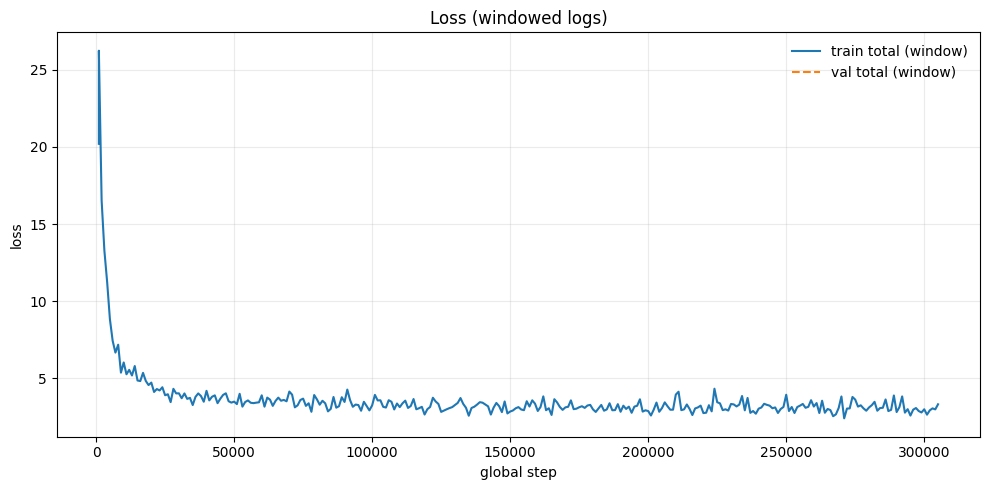

In [11]:
train_st = df[df["split"] == "train_step"].copy()
val_st   = df[df["split"] == "val_step"].copy()

fig, ax = plt.subplots(figsize=(10, 5))

if "loss" in train_st.columns:
    ax.plot(train_st["step"], train_st["loss"], "-", label="train total (window)")
if "loss" in val_st.columns:
    ax.plot(val_st["step"], val_st["loss"], "--", label="val total (window)")

ax.set_xlabel("global step")
ax.set_ylabel("loss")
ax.set_title("Loss (windowed logs)")
ax.grid(alpha=0.25)
ax.legend(frameon=False)
plt.tight_layout()
plt.show()
